Importación de bibliotecas necesarias para el proyecto

In [13]:
import numpy as np                 #Biblioteca de funciones matemáticas de python
import matplotlib.pyplot as plt    #Biblioteca para crear gráficas y visualización de la data
import pandas as pd                #Biblioteca usada para el manejo de dataframes
import pandas_datareader as web    #Esta biblioteca permite leer los datos de forma remota desde Yahoo Finance
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

import datetime as dt  #Para la configuración de los periodos  de incion y fin de la extracción de la data a analizar

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Carga de datos

In [14]:

#Uso del ticker (identificador) de acuerdo a la compañía de interés
company='FB'


#Configuración de la fecha de incio y fin de la extracción de datos

start=dt.datetime(2012,1,1)
end=dt.datetime(2019,1,1)

#Uso del ticker de acuerdo a la compañía de interés

data=web.DataReader(company, 'yahoo', start, end)


#Se muesra el dataframe generado en el periodo de tiepo seleccionado en las variables start y end
print(data)



                  High         Low        Open       Close     Volume  \
Date                                                                    
2012-05-18   45.000000   38.000000   42.049999   38.230000  573576400   
2012-05-21   36.660000   33.000000   36.529999   34.029999  168192700   
2012-05-22   33.590000   30.940001   32.610001   31.000000  101786600   
2012-05-23   32.500000   31.360001   31.370001   32.000000   73600000   
2012-05-24   33.209999   31.770000   32.950001   33.029999   50237200   
...                ...         ...         ...         ...        ...   
2021-12-27  347.869995  338.010010  338.850006  346.179993   17795000   
2021-12-28  352.709991  345.200012  346.630005  346.220001   16637600   
2021-12-29  349.690002  341.640015  346.910004  342.940002   10747000   
2021-12-30  347.230011  343.220001  344.000000  344.359985   10593300   
2021-12-31  343.440002  336.269989  343.019989  336.350006   12870500   

             Adj Close  
Date                    


Exportar dataframe a CSV (extra)

In [15]:
data.to_csv (r'D:\Documentos\2022-2 FI-UNAM 10mo Semestre\SIAFI\GAINS\dataframe2.csv', index = True, header=True)

Preprocesamiento de los datos para la red neuronal

In [16]:
#Normalización de los datos (todos las variables tendrán valores entre cero y uno)
scaler=MinMaxScaler(feature_range=(0,1))

#Transformación del precio de cierre, i.e. la variable que se va a predecir en el formato requerido para la implementación de la red
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))

#Muestra del precio de cierre normalizado
print(scaled_data)

#Muestra de número de datos --> Formato: (numero de filas, número de columnas)
print(scaled_data.shape)

[[0.05624914]
 [0.04472493]
 [0.03641103]
 ...
 [0.89233093]
 [0.89622717]
 [0.8742489 ]]
(2422, 1)


Definición del número de días desde los cuales quiero basar la predicción (i.e. desde qué número de días (desde qué índice) se van a usar para entrenar a la red)

In [17]:
#¿En cuántos días quiero basar mis predicciones?
prediction_days=60

Creación de 2 listas vacías para empezar a preparar los datos de entrenamiento

In [63]:
x_train = []
y_train = []

#Se inicia desde el índice 60 hasta el último índice del dataset
for x in range(prediction_days, len(scaled_data)-1):
    #print(x)
    #Se agrega cada vez un valor normalizado a x_train con cada iteración
    x_train.append(scaled_data[x-prediction_days: x-1,0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [64]:
#Estructura de x_train
print(x_train)
print(x_train.shape)

#Estructura de y_train
print(y_train)
print(y_train.shape)

[[[0.05624914]
  [0.04472493]
  [0.03641103]
  ...
  [0.00820414]
  [0.00899986]
  [0.01119495]]

 [[0.04472493]
  [0.03641103]
  [0.03915489]
  ...
  [0.00899986]
  [0.01119495]
  [0.01061874]]

 [[0.03641103]
  [0.03915489]
  [0.04198107]
  ...
  [0.01119495]
  [0.01061874]
  [0.00727123]]

 ...

 [[0.89252302]
  [0.84648105]
  [0.86494717]
  ...
  [0.86834962]
  [0.85806014]
  [0.87120317]]

 [[0.84648105]
  [0.86494717]
  [0.86681306]
  ...
  [0.85806014]
  [0.87120317]
  [0.90122102]]

 [[0.86494717]
  [0.86681306]
  [0.85468516]
  ...
  [0.87120317]
  [0.90122102]
  [0.90133079]]]
(2361, 59, 1)
[0.00727123 0.0095212  0.00587187 ... 0.90133079 0.89233093 0.89622717]
(2361,)


Construyendo el modelo de la Red Neuronal Recurrente (RNN)

Tipo de RNN que se usará para el modelo: LSTM (Redes neuronales recurrentes de tipo Memoria a Corto y Largo Plazo: Long Short-Term Memory)

"Las LSTM son un tipo especial de redes recurrentes. La característica principal de las redes recurrentes es que la información puede persistir introduciendo bucles en el diagrama de la red, por lo que, básicamente, pueden «recordar» estados previos y utilizar esta información para decidir cuál será el siguiente. Esta característica las hace muy adecuadas para manejar series cronológicas. Mientras las redes recurrentes estándar pueden modelar dependencias a corto plazo (es decir, relaciones cercanas en la serie cronológica), las LSTM pueden aprender dependencias largas, por lo que se podría decir que tienen una «memoria» a más largo plazo."

Para más información, consultar: 

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/ 

http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 

https://blog.gft.com/es/2018/11/06/como-usar-redes-neuronales-lstm-en-la-prediccion-de-averias-en-las-maquinas/ 

Función para entrenar a la red

In [66]:
def LSTM_model():
    
    model = Sequential()
    
    #Las unidades especificadas se refiere al número de capas que tendrá la red

    #Return sequence es el parámetro aque permitirá el feedback entre las capas de la red neuronal, lo cual mejora el aprendizaje

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    #Las capas dropout ayudan a evitar el overfitting en el modelo (sobreajuste) sin eliminar valores
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    #Las dropout layers sólo se colocan en las capas totalmente conectadas solo porque son las que tienen la mayor cantidad de parámetros y, por lo tanto, es probable que se coadapten excesivamente y provoquen un sobreajuste
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    #Capa densa que hará la predicción del precio de cierre
    model.add(Dense(units=1))
    
    return model


    #https://datascience.stackexchange.com/questions/12964/what-is-the-meaning-of-the-number-of-units-in-the-lstm-cell

Entrenamineto de la red

In [67]:
model = LSTM_model()
model.summary()
#Un optimizador es uno de los dos argumentos necesarios para compilar un modelo de Keras
#La pérdida del error cuadrático medio, o MSE, es la pérdida predeterminada que se utiliza para los problemas de regresión
#El error cuadrático medio se calcula como el promedio de las diferencias al cuadrado entre los valores predichos y reales. El resultado siempre es positivo independientemente del signo de los valores previstos y reales y un valor perfecto es 0,0. El cuadrado significa que los errores más grandes dan como resultado más errores que los errores más pequeños, lo que significa que el modelo es castigado por cometer errores más grandes.
model.compile(optimizer='adam', loss='mean_squared_error')

#https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
#https://keras.io/api/optimizers/ 
#https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 59, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 59, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 59, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 59, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

Entrenamiento del modelo

In [69]:
# Devolución de llamada para guardar el modelo Keras o los pesos del modelo con alguna frecuencia.
#https://keras.io/api/callbacks/model_checkpoint/

#La devolución de llamada se usa junto con el uso de entrenamiento model.fit()para guardar un modelo o pesos (en un archivo de punto de control) en algún intervalo, de modo que el modelo o los pesos se puedan cargar más tarde para continuar el entrenamiento desde el estado guardado.


# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)
history=model.fit(x_train, 
          y_train, 
          epochs=25,          #Número de veces (épocas) que se va a entrenar el modelo
          batch_size = 32,    #El número de datos que verá el modelo a la vez todo el tiempo durante el entrenamiento
          callbacks = [checkpointer])

Epoch 1/25
74/74 [==============================] - 4s 54ms/step - loss: 0.0015
Epoch 2/25
74/74 [==============================] - 4s 51ms/step - loss: 0.0013
Epoch 3/25
74/74 [==============================] - 4s 52ms/step - loss: 0.0014
Epoch 4/25
74/74 [==============================] - 4s 54ms/step - loss: 0.0012
Epoch 5/25
74/74 [==============================] - 4s 56ms/step - loss: 0.0014
Epoch 6/25
74/74 [==============================] - 4s 51ms/step - loss: 0.0012
Epoch 7/25
74/74 [==============================] - 4s 56ms/step - loss: 0.0012
Epoch 8/25
74/74 [==============================] - 5s 65ms/step - loss: 0.0013
Epoch 9/25
74/74 [==============================] - 4s 56ms/step - loss: 0.0011
Epoch 10/25
74/74 [==============================] - 4s 51ms/step - loss: 0.0012
Epoch 11/25
74/74 [==============================] - 5s 64ms/step - loss: 0.0011
Epoch 12/25
74/74 [==============================] - 4s 56ms/step - loss: 0.0011
Epoch 13/25
74/74 [==================

In [ ]:
def fit_model(model, BATCH_SIZE, N_EPOCH):
    
    return model.fit(self.X_train, self.y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(self.X_test, self.y_test),verbose=2, shuffle=False)

In [72]:
def plot_train_results(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()



Guardando el mejor modelo con base en el número de veces que se entrenó al algoritmo

In [23]:
from keras.models import load_model
from keras.models import Model
model.save('weights_best.hdf5')  # creates a HDF5 file 'weights_best.hdf5'

Predicciones

Test de la precisión del modelo entrenado guardado comparado con los datos existentes

Función para la carga de datos

In [26]:
def load_data(company, start, end):
    data = web.DataReader(company, 'yahoo', start, end)
    return data

Carga de datos con DataReader por medio de Yahoo Finance para las acciones de facebook desde el 2019

In [28]:
test_data = load_data(company = 'FB',
                      start = dt.datetime(2019,1,2),
                      end = dt.datetime.now())

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

Realizando las predicciones sobre los datos de prueba

In [29]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

Gráfica comparativa entre los datos reales de FB y los datos predecidos por la LSTM RNN

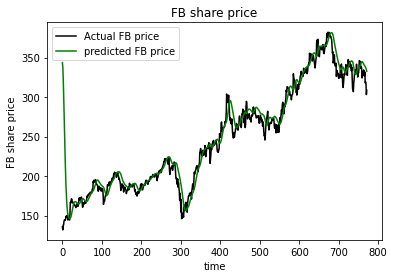

In [30]:
plt.plot(actual_prices, color='black', label=f"Actual {company} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {company} price")
plt.title(f"{company} share price")
plt.xlabel("time")
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

Prediciendo el día siguiente

In [57]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

prediction: [[330.30743]]


Gráfica con la tendencia de los próximos 20 días con base en el modelo

In [45]:
x_test = []
for x in range(prediction_days, len(model_inputs)+1):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

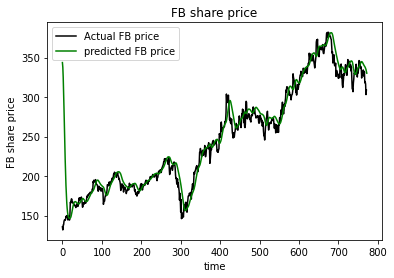

In [46]:
plt.plot(actual_prices, color='black', label=f"Actual {company} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {company} price")
plt.title(f"{company} share price")
plt.xlabel("time")
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

Fuentes de información 

#Stock Prices forecasting with LSTM
https://www.kaggle.com/bryanb/stock-prices-forecasting-with-lstm

#Predicting Stock Prices in Python
https://www.youtube.com/watch?v=PuZY9q-aKLw&t=448s 